In [67]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_csv('data/turnstile_180623.txt')
df2 = pd.read_csv('data/turnstile_180602.txt')
df1.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068


In [3]:
# df_alldata = pd.concat([df1,df2])

Check hierarchy of members

In [65]:
# df1.groupby(['STATION', 'UNIT', 'C/A'])['SCP'].unique().head(5)

STATION
1 AV                              [L]
103 ST                     [BC, 1, 6]
103 ST-CORONA                     [7]
104 ST                        [JZ, A]
110 ST                            [6]
111 ST                      [J, A, 7]
116 ST                    [BC, 6, 23]
116 ST-COLUMBIA                   [1]
121 ST                           [JZ]
125 ST             [ACBD, 1, 456, 23]
Name: LINENAME, dtype: object

In [5]:
## strip whitespace in column headers
newcolumns = df1.columns.str.strip()
df1.columns = newcolumns

In [6]:
df1['DATETIME'] = df1['DATE'] + ' ' + df1['TIME']
df1['DATETIME'] = pd.to_datetime(df1['DATETIME'])
df1.sample(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
147159,R220,R160,01-00-01,ASTOR PL,6,IRT,06/17/2018,01:00:00,REGULAR,553438,1003099,2018-06-17 01:00:00
27599,E014,R374,00-00-03,BAY PKWY,D,BMT,06/21/2018,13:00:00,REGULAR,10556560,11895541,2018-06-21 13:00:00
113929,PTH06,R546,00-00-01,PAVONIA/NEWPORT,1,PTH,06/21/2018,13:33:01,REGULAR,2075383,457621,2018-06-21 13:33:01


In [7]:
df1['ENTRY_DIFFS'] = (df1
                      .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                      .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                      .diff())
df1['EXIT_DIFFS'] = (df1
                     .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                     .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                     .diff())

In [8]:
## check to make sure NaN appears for the first row for an SCP
df1[40:].head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,16:00:00,REGULAR,6666235,2259814,2018-06-22 16:00:00,329.0,74.0
41,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,20:00:00,REGULAR,6666924,2259874,2018-06-22 20:00:00,689.0,60.0
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,5964171,1334598,2018-06-16 00:00:00,NaN,NaN
43,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,5964188,1334606,2018-06-16 04:00:00,17.0,8.0
44,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,5964202,1334630,2018-06-16 08:00:00,14.0,24.0


In [9]:
## purge values that don't make any sense in ENTRY_DIFFS and EXIT_DIFFS
df1.loc[df1['ENTRY_DIFFS'] < 0, 'ENTRY_DIFFS'] = 0
df1.loc[df1['ENTRY_DIFFS'] > 100000, 'ENTRY_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] < 0, 'EXIT_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] > 100000, 'EXIT_DIFFS'] = 0

In [10]:
## make series of weekly total SCP-entry_diffs and SCP-exit_diffs pairs
SCP_ENTRY_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_EXIT_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'EXIT_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXIT_DIFFS']
                  .sum())
SCP_ENTRY_weektotals.head(5)

STATION  UNIT  C/A   SCP     
1 AV     R248  H007  00-00-00    24023.0
                     00-00-01    31421.0
                     00-03-00     6240.0
                     00-03-01     4825.0
                     00-03-02     8038.0
Name: ENTRY_DIFFS, dtype: float64

(array([1871., 1302.,  806.,  429.,  174.,   75.,   33.,   10.,    8.,
           2.]),
 array([    0. ,  4524.3,  9048.6, 13572.9, 18097.2, 22621.5, 27145.8,
        31670.1, 36194.4, 40718.7, 45243. ]),
 <a list of 10 Patch objects>)

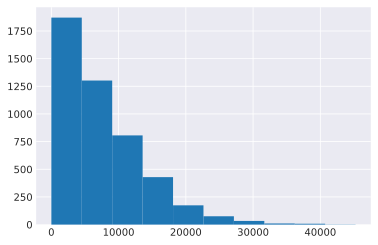

In [68]:
plt.hist(SCP_ENTRY_weektotals)

In [12]:
## display the highest-traffic stations for this week (all entries+ all exits)
STATION_traffic_weektotals = (SCP_ENTRY_weektotals + SCP_EXIT_weektotals).groupby(['STATION']).sum()
STATION_traffic_weektotals.sort_values(ascending=False).head(10)

STATION
34 ST-PENN STA     1868658.0
GRD CNTRL-42 ST    1711147.0
34 ST-HERALD SQ    1387533.0
14 ST-UNION SQ     1220524.0
TIMES SQ-42 ST     1218558.0
23 ST              1116914.0
FULTON ST          1078230.0
42 ST-PORT AUTH    1019479.0
86 ST               876680.0
125 ST              873321.0
dtype: float64

In [13]:
# df1['DATETIME'].min() + timedelta(days=1)
# df1['DATETIME'].max()

Timestamp('2018-06-17 00:00:00')

In [23]:
## make an array of midnight datetimes for slicing dataframe by days
day_markers = np.arange(df1['DATETIME'].min(), df1['DATETIME'].max(), timedelta(days=1))
day_markers = np.append(day_markers, df1['DATETIME'].max())
day_markers

array([datetime.datetime(2018, 6, 16, 0, 0),
       datetime.datetime(2018, 6, 17, 0, 0),
       datetime.datetime(2018, 6, 18, 0, 0),
       datetime.datetime(2018, 6, 19, 0, 0),
       datetime.datetime(2018, 6, 20, 0, 0),
       datetime.datetime(2018, 6, 21, 0, 0),
       datetime.datetime(2018, 6, 22, 0, 0),
       Timestamp('2018-06-22 23:58:32')], dtype=object)

In [17]:
first_datetime = df1['DATETIME'].min()
df_day1 = df1[(df1['DATETIME'] > first_datetime)&(df1['DATETIME'] <= first_datetime + timedelta(days=1))]
df_day1.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036,2018-06-16 04:00:00,22.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068,2018-06-16 08:00:00,19.0,32.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139,2018-06-16 12:00:00,100.0,71.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188,2018-06-16 16:00:00,177.0,49.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,20:00:00,REGULAR,6659281,2257223,2018-06-16 20:00:00,238.0,35.0


In [51]:
SCP_ENTRY_day1totals = (df_day1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_ENTRY_day1totals.sort_values(ascending=False).head(5)

STATION          UNIT  C/A   SCP     
QUEENSBORO PLZ   R121  R509  00-00-00    7008.0
BEDFORD AV       R235  H009  00-03-04    6830.0
QUEENSBORO PLZ   R121  R509  00-00-01    5634.0
BEDFORD AV       R235  H009  00-03-03    4665.0
34 ST-HERALD SQ  R022  N506  00-05-05    4608.0
Name: ENTRY_DIFFS, dtype: float64

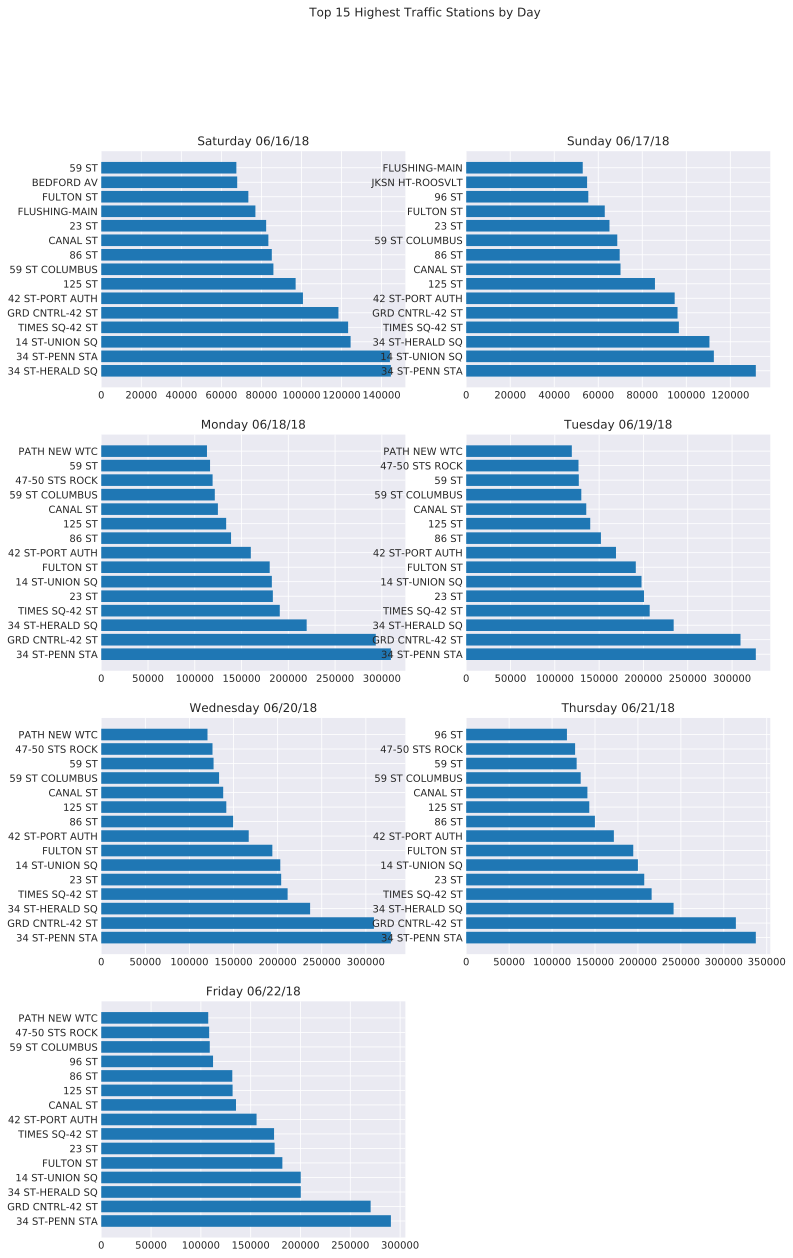

In [69]:
## This code generates bar charts for each day's top 10 highest-traffic stations

## Number of stations to be returned. (Top 10? Top 15?)
snum = 15

plt.figure(figsize=[12,20])
plt.suptitle("Top %d Highest Traffic Stations by Day" % snum)

for index, day in enumerate(day_markers[:-1]):
    
    ## Slice dataframe to a single day's values
    df_day = df1[(df1['DATETIME'] > day)&(df1['DATETIME'] <= day_markers[index+1])]
    
    ## Sum every station's entries and exits for the day
    STATION_ENTRY_daytotals = (df_day
                  .sort_values(by=['STATION'])[['STATION', 'ENTRY_DIFFS']]
                  .groupby(['STATION'])['ENTRY_DIFFS']
                  .sum())
    STATION_EXIT_daytotals = (df_day
                  .sort_values(by=['STATION'])[['STATION', 'EXIT_DIFFS']]
                  .groupby(['STATION'])['EXIT_DIFFS']
                  .sum())
    
    ## Aggregate entry and exit data into one column (total traffic)
    STATION_BOTH_daytotals = (STATION_ENTRY_daytotals + STATION_EXIT_daytotals).groupby(['STATION']).sum()
    
    STATION_BOTH_daytotals.sort_values(ascending=False, inplace=True)
    
    ## Make a list of station names for labeling bar chart
    ticks_y = STATION_BOTH_daytotals[:snum].index.tolist()
    
    plt.subplot(4, 2, index+1)
    plt.barh(np.arange(snum),STATION_BOTH_daytotals.values[:snum])
    plt.yticks(np.arange(snum), ticks_y)
    plt.title(day.strftime("%A %m/%d/%y"))

In [80]:
first_datetime.date() - timedelta(days=1)

datetime.date(2018, 6, 15)

In [84]:
df1.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['DATETIME'].diff().sort_values(ascending=False).dropna()

26386    3 days 00:00:00
112668   2 days 16:53:10
116634   2 days 16:44:48
137709   2 days 16:00:00
137736   2 days 16:00:00
36639    2 days 04:00:00
77134    1 days 12:00:00
60002    1 days 12:00:00
119340   1 days 05:29:03
68447    1 days 04:00:00
171804   1 days 04:00:00
113053   1 days 01:20:51
16542    1 days 00:00:00
112669   0 days 21:46:14
127694   0 days 20:00:00
112533   0 days 18:50:58
113052   0 days 18:15:57
176672   0 days 16:00:00
149990   0 days 16:00:00
88616    0 days 16:00:00
41652    0 days 16:00:00
118786   0 days 12:49:06
72415    0 days 12:00:00
4794     0 days 12:00:00
77131    0 days 12:00:00
119736   0 days 10:02:12
111660   0 days 09:55:38
118063   0 days 08:24:00
4868     0 days 08:00:00
104556   0 days 08:00:00
               ...      
132330   0 days 00:01:00
132376   0 days 00:01:00
132514   0 days 00:01:00
132560   0 days 00:01:00
132606   0 days 00:01:00
132468   0 days 00:01:00
132698   0 days 00:00:59
132652   0 days 00:00:59
132653   0 days 00:00:24


In [89]:
df1[116630:116650]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
116630,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/17/2018,05:32:01,REGULAR,2060052,1638231,2018-06-17 05:32:01,0.0,0.0
116631,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/17/2018,09:44:01,REGULAR,2060052,1638231,2018-06-17 09:44:01,0.0,0.0
116632,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/17/2018,13:56:01,REGULAR,2060052,1638231,2018-06-17 13:56:01,0.0,0.0
116633,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/17/2018,18:08:01,REGULAR,2060052,1638231,2018-06-17 18:08:01,0.0,0.0
116634,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/20/2018,10:52:49,REGULAR,2060052,1642989,2018-06-20 10:52:49,0.0,4758.0
116635,PTH13,R541,00-04-06,THIRTY ST,1,PTH,06/20/2018,15:04:49,REGULAR,2060052,1643614,2018-06-20 15:04:49,0.0,625.0
116636,PTH13,R541,00-04-07,THIRTY ST,1,PTH,06/16/2018,03:22:07,REGULAR,1,147640,2018-06-16 03:22:07,NaN,NaN
116637,PTH13,R541,00-04-07,THIRTY ST,1,PTH,06/16/2018,07:34:07,REGULAR,1,147775,2018-06-16 07:34:07,0.0,135.0
116638,PTH13,R541,00-04-07,THIRTY ST,1,PTH,06/16/2018,11:46:07,REGULAR,1,147832,2018-06-16 11:46:07,0.0,57.0
116639,PTH13,R541,00-04-07,THIRTY ST,1,PTH,06/16/2018,15:58:07,REGULAR,1,148457,2018-06-16 15:58:07,0.0,625.0


In [97]:
df1['ENTRY_DIFFS'].mean()

179.93194982706171